# Mortgage Data Retrieval

In [1]:
import pandas as pd
import numpy as np

import pyodbc
# from fnbbase.connection import * 
# from pandasql import sqldf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pysqldf = lambda q: sqldf(q, globals())
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Connection driver removed for privacy reasons
cnxn = pyodbc.connect()

TypeError: no connection information was passed

#### Get account values for Trust and Brokerage accounts

In [3]:
# Variables removed for privacy reasons
trustBrkgeQuery = """
SELECT

  FROM [FNB_PADaily].[dbo].accts
  WHERE sstatus = 'A'
"""

In [4]:
trustBrkge = pd.read_sql(trustBrkgeQuery, cnxn)

NameError: name 'cnxn' is not defined

In [5]:
# Reduce trust and brokerage values to two columns: hkey and MARKETVAL
trust = trustBrkge[trustBrkge["PRODUCT"] == "18"]
trust = trust.drop(columns = ["PRODUCT"])
trust = trust.rename(columns = {"MARKETVAL" : "trustbal"})
trust = trust.groupby(by = "hkey").sum().reset_index()
brkge = trustBrkge[trustBrkge["PRODUCT"] == "17"]
brkge = brkge.drop(columns = ["PRODUCT"])
brkge = brkge.rename(columns = {"MARKETVAL" : "brkgebal"})
brkge = brkge.groupby(by = "hkey").sum().reset_index()

NameError: name 'trustBrkge' is not defined

In [6]:
trustBrkge = pd.merge(trust, brkge, how = "outer", on = "hkey")

NameError: name 'trust' is not defined

**Get all the product details of the households**

In [7]:
# Variables removed for privacy reasons
allProdQuery = """
SELECT 

  FROM [FNB_PADaily].[dbo].hhold 
  where sstatus = 'A'
"""

In [8]:
allProd = pd.read_sql(allProdQuery, cnxn)

NameError: name 'cnxn' is not defined

In [9]:
allProd.shape

NameError: name 'allProd' is not defined

In [10]:
allProd.head()

NameError: name 'allProd' is not defined

**Retrieving mortgage only households**

In [11]:
# Variables removed for privacy reasons
mtgonlyQuery = """
SELECT 

  FROM [FNB_PADaily].[dbo].hhold 
  where sstatus = 'A'
"""

In [12]:
mtgOnly = pd.read_sql(mtgonlyQuery, cnxn)

NameError: name 'cnxn' is not defined

**Get the demographics data for the households**

In [13]:
# Variables removed for privacy reasons
demoQuery = """
select      
      from [ExecutraxSystem].[dbo].[L70OHVIE]
"""

In [14]:
demoData = pd.read_sql(demoQuery, cnxn)

NameError: name 'cnxn' is not defined

In [15]:
demoData.shape

NameError: name 'demoData' is not defined

<font color = 'blue'>**The above demographic data is modified(some fields are added and some are deleted). Right now we are still using the above table but we will be updating the model with the new table.**</font>

**Get the demographics data for the households from the new table**

In [16]:
# Variables removed for privacy reasons
newdemoQuery = """
select    
from [ExecutraxSystem].[dbo].[LM0QDCQB]
"""

In [17]:
newdemoData = pd.read_sql(newdemoQuery, cnxn)

NameError: name 'cnxn' is not defined

**As you may have noticed, 'age' and 'gender' apart from 'occupation' and 'preschld' are missing. So we retrieve 'age' and 'gender' from our existing Accounts table.** 

In [18]:
# Variables removed for privacy reasons
demo2Query = """
SELECT

  FROM [FNB_PADaily].[dbo].[Accts]
  where sstatus = 'A'
"""


In [19]:
demo2Data = pd.read_sql(demo2Query, cnxn)

NameError: name 'cnxn' is not defined

## Data Preparation (Connor 6/11)

In [20]:
# merge all of the demographic data
allDemoData = pd.merge(left = newdemoData, right = demo2Data, left_on = "hkey", right_on = "hkey")

NameError: name 'newdemoData' is not defined

In [21]:
# merge demographic data for customers with ONLY a mortgage
mtgOnlyDemo = pd.merge(left = allDemoData, right = mtgOnly, left_on = "hkey", right_on = "hkey")

NameError: name 'allDemoData' is not defined

In [22]:
# merge demographic data for customers of all products
allProdDemo = pd.merge(left = allDemoData, right = allProd, left_on = "hkey", right_on = "hkey")

NameError: name 'allDemoData' is not defined

In [23]:
# get demographic data for customers without a mortgage
nonMtgDemo = allProdDemo[allProdDemo["MTG_Num"] == 0]

NameError: name 'allProdDemo' is not defined

In [24]:
# get demographic data for all customers with a mortgage
# FIRST MAIN DATASET
mtgDemo = allProdDemo[allProdDemo["MTG_Num"] > 0]

NameError: name 'allProdDemo' is not defined

In [25]:
# get demographic data for customers with a mortgage (but not only)
# SECOND MAIN DATASET
mtgDemoMinusOnly = mtgDemo.copy()
cond = mtgDemoMinusOnly["hkey"].isin(mtgOnlyDemo["hkey"])
mtgDemoMinusOnly.drop(mtgDemoMinusOnly[cond].index, inplace = True)

NameError: name 'mtgDemo' is not defined

In [26]:
print(mtgDemoMinusOnly.shape)
print(mtgDemo.shape)

NameError: name 'mtgDemoMinusOnly' is not defined

Almost half of our mortgage customers are mortgage only customers

In [27]:
# Combine mortgage demo data with all other products (so that we have a binary response 0 or 1)
mtgDemo = pd.concat([mtgDemo, nonMtgDemo])
mtgDemoMinusOnly = pd.concat([mtgDemoMinusOnly, nonMtgDemo])

NameError: name 'mtgDemo' is not defined

In [28]:
# Add column designating whether the household has a mortgage
mtgDemo["has_mtg"] = np.where(mtgDemo["MTG_Num"] > 0, 1, 0)
mtgDemoMinusOnly["has_mtg"] = np.where(mtgDemoMinusOnly["MTG_Num"] > 0, 1, 0)

NameError: name 'mtgDemo' is not defined

In [29]:
# Add Trust and Brokerage Balances merged on hkey
mtgDemo = pd.merge(mtgDemo, trustBrkge, how = "left", on = "hkey")
mtgDemoMinusOnly = pd.merge(mtgDemoMinusOnly, trustBrkge, how = "left", on = "hkey")

# Fill in the nans
mtgDemo['trustbal'].fillna(0, inplace = True)
mtgDemo['brkgebal'].fillna(0, inplace = True)

mtgDemoMinusOnly['trustbal'].fillna(0, inplace = True)
mtgDemoMinusOnly['brkgebal'].fillna(0, inplace = True)

mtgDemo.head()

NameError: name 'mtgDemo' is not defined

In [30]:
print(mtgDemo.shape)
# Mortgage customers
print(mtgDemo[mtgDemo.has_mtg == 1].shape)
# Non-mortgage customers
print(mtgDemo[mtgDemo.has_mtg == 0].shape)
# Cross sell mortgage customers
print(mtgDemoMinusOnly[mtgDemoMinusOnly.has_mtg == 1].shape)

NameError: name 'mtgDemo' is not defined

## Missing Values

In [31]:
pd.set_option("display.max_columns", None)
mtgDemo.head()

NameError: name 'mtgDemo' is not defined

#### The gender column has some blank values, we will replace those with NA so we can see if there is a pattern in the Nas

In [32]:
print(mtgDemo['gender'].value_counts())
print(mtgDemoMinusOnly['gender'].value_counts())
print(nonMtgDemo['gender'].value_counts())

NameError: name 'mtgDemo' is not defined

In [33]:
# replacing the 0 in the gender column to NA's to capture missing values
mtgDemo['gender'] = mtgDemo['gender'].replace(r'^\s*$', np.nan, regex=True)
mtgDemoMinusOnly['gender'] = mtgDemoMinusOnly['gender'].replace(r'^\s*$', np.nan, regex=True)
nonMtgDemo['gender'] = nonMtgDemo['gender'].replace(r'^\s*$', np.nan, regex=True)

NameError: name 'mtgDemo' is not defined

Not sure why we are getting this warning, but the function does the right thing anyways

In [34]:
# Checking to make sure the replace was completed
print(mtgDemo['gender'].value_counts())
print(mtgDemoMinusOnly['gender'].value_counts())
print(nonMtgDemo['gender'].value_counts())

NameError: name 'mtgDemo' is not defined

#### All Mortgage Customers

In [35]:
# Missing Values in all mortgage customers
for c in mtgDemo.columns:
    if mtgDemo[c].isna().sum() > 0:
        print("---- %s ---" % c)
        print(mtgDemo[c].isna().sum())

NameError: name 'mtgDemo' is not defined

In [36]:
# Variables removed for privacy reasons
sns.heatmap(mtgDemo[[]].isnull(), cbar=False);

NameError: name 'mtgDemo' is not defined

#### Cross Sell Mortgage Customers

In [37]:
# Missing Values in cross sell mortgage customers
for c in mtgDemoMinusOnly.columns:
    if mtgDemoMinusOnly[c].isna().sum() > 0:
        print("---- %s ---" % c)
        print(mtgDemoMinusOnly[c].isna().sum())

NameError: name 'mtgDemoMinusOnly' is not defined

In [38]:
# Variables removed for privacy reasons
sns.heatmap(mtgDemoMinusOnly[['educate','income','ownrent','loantovalue','gender','homemktvalue','age']].isnull(), cbar=False);

NameError: name 'mtgDemoMinusOnly' is not defined

#### Non-Mortgage Customers

In [39]:
# Missing Values in non mortgage customers
for c in nonMtgDemo.columns:
    if nonMtgDemo[c].isna().sum() > 0:
        print("---- %s ---" % c)
        print(nonMtgDemo[c].isna().sum())

NameError: name 'nonMtgDemo' is not defined

In [40]:
# Variables removed for privacy reasons
sns.heatmap(nonMtgDemo[['educate','income','ownrent','loantovalue','gender','homemktvalue','age']].isnull(), cbar=False);

NameError: name 'nonMtgDemo' is not defined

## to get rid of missing values or not, that is the question

In [41]:
print(mtgDemo.shape)
print(mtgDemoMinusOnly.shape)

NameError: name 'mtgDemo' is not defined

In [42]:
mtgDemo = mtgDemo[mtgDemo["age"].notna()]
mtgDemo = mtgDemo[mtgDemo["homemktvalue"].notna()]                  
mtgDemoMinusOnly = mtgDemoMinusOnly[mtgDemoMinusOnly["age"].notna()]
mtgDemoMinusOnly = mtgDemoMinusOnly[mtgDemoMinusOnly["homemktvalue"].notna()]

NameError: name 'mtgDemo' is not defined

In [43]:
print(mtgDemo.shape)
# Mortgage customers
print(mtgDemo[mtgDemo.has_mtg == 1].shape)
# Non-mortgage customers
print(mtgDemo[mtgDemo.has_mtg == 0].shape)
# Cross sell mortgage customers
print(mtgDemoMinusOnly[mtgDemoMinusOnly.has_mtg == 1].shape)

NameError: name 'mtgDemo' is not defined

## Data Visualizations

In [44]:
mtgDemo.describe()

NameError: name 'mtgDemo' is not defined

In [45]:
mtgDemoMinusOnly.describe()

NameError: name 'mtgDemoMinusOnly' is not defined

In [46]:
# Comparison of 2 continuous variables
plt.figure(figsize = (15, 12))
plt.scatter(nonMtgDemo["age"], nonMtgDemo["annspend"], color = "red")
plt.scatter(mtgOnlyDemo["age"], mtgOnlyDemo["annspend"], color = "blue")
plt.scatter(mtgDemoMinusOnly["age"], mtgDemoMinusOnly["annspend"], color = "green")
plt.show;

NameError: name 'nonMtgDemo' is not defined

<Figure size 1080x864 with 0 Axes>

In [47]:
# Counts of mortgage owners in each dataset
print(mtgDemo["has_mtg"].value_counts())
print(mtgDemoMinusOnly["has_mtg"].value_counts())

NameError: name 'mtgDemo' is not defined

NameError: name 'mtgDemo' is not defined

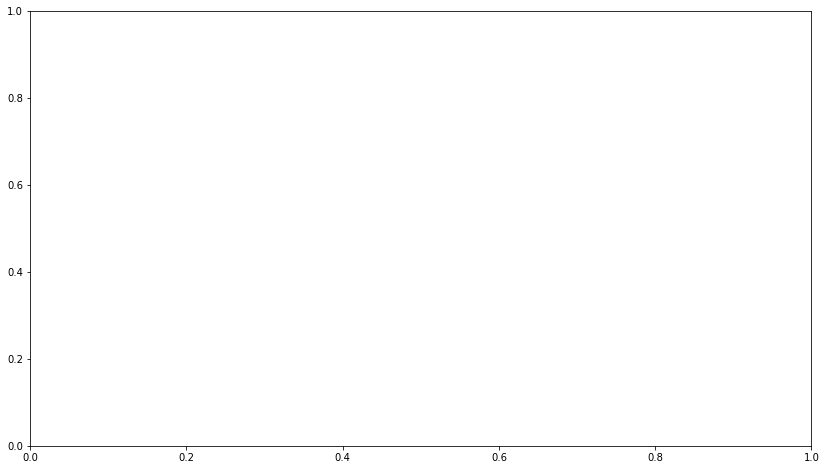

In [48]:
# Plot count plots
fig, axs = plt.subplots(1, 1, figsize = (14, 8))
sns.countplot(x = "has_mtg", data = mtgDemo, color = "black")
sns.countplot(x = "has_mtg", data = mtgDemoMinusOnly, palette = "hls")
plt.xlabel("Has Mortgage")

# We see that the data is imbalanced for both datasets

In [ ]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["educate"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["educate"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")

NameError: name 'mtgDemo' is not defined

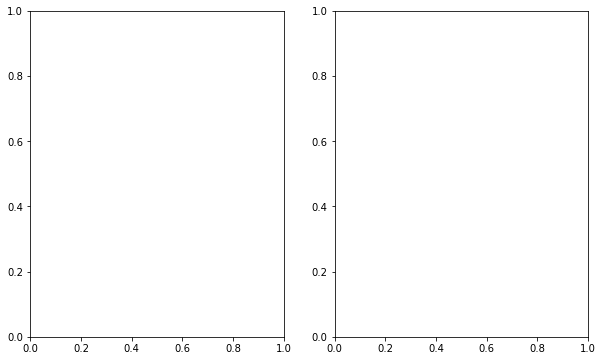

In [49]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["gender"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["gender"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")



In [ ]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["ownrent"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["ownrent"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")


NameError: name 'mtgDemo' is not defined

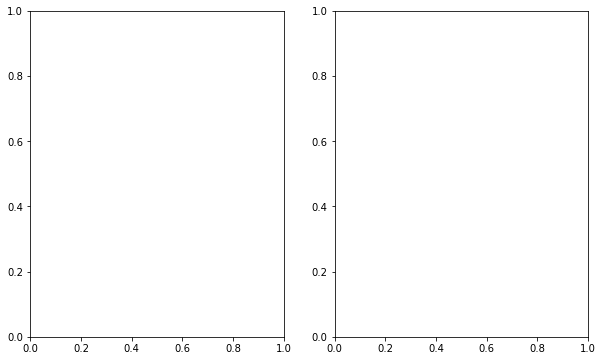

In [50]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["income"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["income"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")


NameError: name 'mtgDemo' is not defined

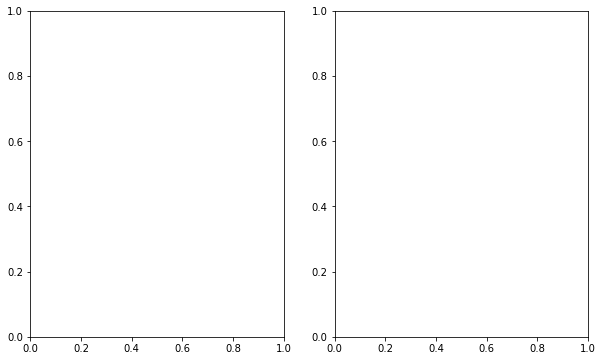

In [51]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["lor"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["lor"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")


NameError: name 'mtgDemo' is not defined

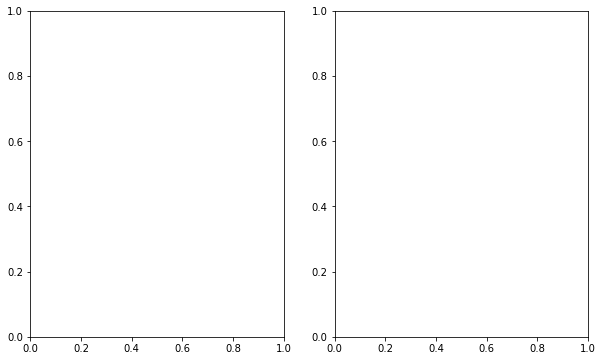

In [52]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["espscore"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["espscore"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")


In [ ]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["howner"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["howner"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")

NameError: name 'mtgDemo' is not defined

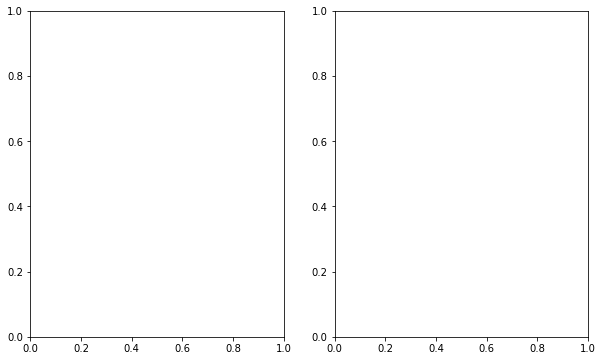

In [53]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["networth"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["networth"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")

In [ ]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["homemktvalue"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["homemktvalue"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")

NameError: name 'mtgDemo' is not defined

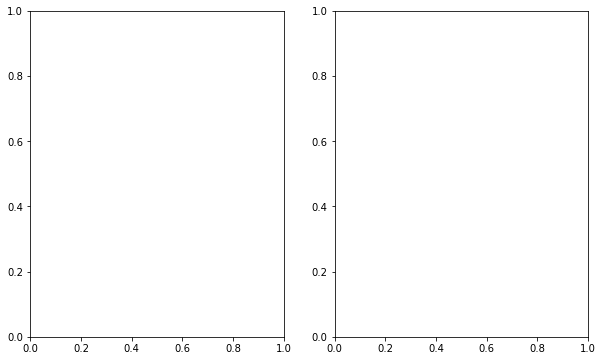

In [54]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

pd.crosstab(mtgDemo["loantovalue"], mtgDemo["has_mtg"]).plot(ax = ax[0], kind = "bar")
ax[0].set_title("All Data")
pd.crosstab(mtgDemoMinusOnly["loantovalue"], mtgDemoMinusOnly["has_mtg"]).plot(ax = ax[1], kind = "bar")
ax[1].set_title("Minus Mortgage Only")

In [ ]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

sns.histplot(data = mtgDemo, ax = ax[0], stat = "count", multiple = "stack", x = "annspend", 
             kde = False, palette = "pastel", hue = "has_mtg", element = "bars", legend = True).set(xlim = (0, 20000), ylim = (0, 25000))
ax[0].set_title("All Data")
sns.histplot(data = mtgDemoMinusOnly, ax = ax[1], stat = "count", multiple = "stack", x = "annspend", 
             kde = False, palette = "pastel", hue = "has_mtg", element = "bars", legend = True).set(xlim = (0, 20000), ylim = (0, 25000))
ax[1].set_title("Minus Mortgage Only")

NameError: name 'mtgDemo' is not defined

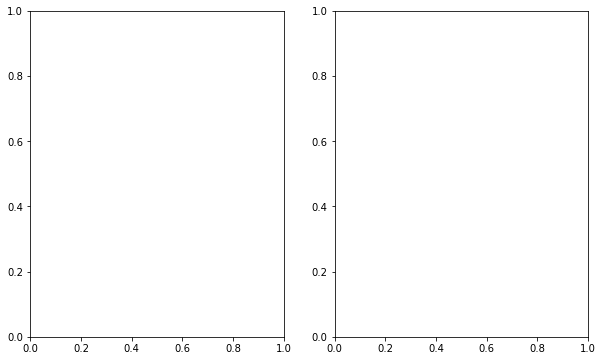

In [55]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

sns.histplot(data = mtgDemo, ax = ax[0], stat = "count", multiple = "stack", x = "age", 
             kde = False, palette = "pastel", hue = "has_mtg", element = "bars", legend = True).set(xlim = (0, 120), ylim = (0, 12500))
ax[0].set_title("All Data")
sns.histplot(data = mtgDemoMinusOnly, ax = ax[1], stat = "count", multiple = "stack", x = "age", 
             kde = False, palette = "pastel", hue = "has_mtg", element = "bars", legend = True).set(xlim = (0, 120), ylim = (0, 12500))
ax[1].set_title("Minus Mortgage Only")

In [ ]:
# Plot different cross-tabulations based on categorical variables
# Also plot histograms for continuous variables
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

sns.histplot(data = mtgDemo, ax = ax[0], stat = "count", multiple = "stack", x = "TENURE", 
             kde = False, palette = "pastel", hue = "has_mtg", element = "bars", legend = True).set(xlim = (0, 60), ylim = (0, None))
ax[0].set_title("All Data")
sns.histplot(data = mtgDemoMinusOnly, ax = ax[1], stat = "count", multiple = "stack", x = "TENURE", 
             kde = False, palette = "pastel", hue = "has_mtg", element = "bars", legend = True).set(xlim = (0, 60), ylim = (0, None))
ax[1].set_title("Minus Mortgage Only")

#### Not sure if histograms make sense for the account variables

#### Decision to eliminate "loantovalue" from dataset because there are 300000 NAs (6/15) Ask Carrie
#### Drop gender and ownrent, drop dummies for income and education, fill NA with -1 for lor
#### Drop all types of accounts with 0 balance or 0 accounts

# Excluded Code from final model notebook

In [56]:
# # Calculate p-values
# # Derivations taken from: https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients

# X_notOnly_design = np.hstack([np.ones((us_data_X_notOnly_train.shape[0], 1)), us_data_X_notOnly_train])

# var_notOnly = np.product((models[best_cv].predict_proba(us_data_X_notOnly_train)), axis = 1)

# covar_notOnly = np.linalg.pinv(np.dot((X_notOnly_design.T * var_notOnly), X_notOnly_design))

# SE_notOnly = np.sqrt(np.diag(covar_notOnly))
# print(SE_notOnly)

# params_notOnly = np.insert(models[best_cv].coef_, 0, models[best_cv].intercept_)

# wald_notOnly = (params_notOnly/SE_notOnly)

# pval_notOnly = scipy.stats.distributions.norm.sf(wald_notOnly)
# print(pval_notOnly)

## Threshold Experimenting

In [57]:
#from tqdm import tqdm_notebook

In [58]:
'''
# see if a different metric makes this better
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm_notebook([i * 0.01 for i in range(100)]):
        # score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        score = metrics.precision_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result
'''

"\n# see if a different metric makes this better\ndef threshold_search(y_true, y_proba):\n    best_threshold = 0\n    best_score = 0\n    for threshold in tqdm_notebook([i * 0.01 for i in range(100)]):\n        # score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)\n        score = metrics.precision_score(y_true=y_true, y_pred=y_proba > threshold)\n        if score > best_score:\n            best_threshold = threshold\n            best_score = score\n    search_result = {'threshold': best_threshold, 'f1': best_score}\n    return search_result\n"

In [59]:
#threshold_search(actuals,probs)

## Interaction Terms and VIF

In [229]:
# for i in X_all_std.columns:
#     X_all_std['Total_NonMtg_Accts_'+ i ] = X_all_std['Total Non-mortgage Accounts'] * X_all_std[i]

In [230]:
X_all_std.shape

(608352, 59)

In [231]:
# corr = X_all_std.corr().values
# flds = list(X_all_std.columns)

In [232]:
# for i in range(0,corr.shape[0]):
#     for j in range(i+1,corr.shape[0]):
#         if corr[i,j] > 0.7 and i != j:
#             print(flds[i], ' ', flds[j], ' ', corr[i,j])

In [233]:
# Multi-collinearity check
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X_all_std.values, i) for i in range(X_all_std.shape[1])]
# vif["features"] = X_all_std.columns
# vif.round(1)

# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X_notOnly_std.values, i) for i in range(X_notOnly_std.shape[1])]
# vif["features"] = X_notOnly_std.columns
# vif.round(1)